In [118]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from time import time
import datetime
from script import RegressionPredictor,LogRegressionPredictor
import japanize_matplotlib
# print(os.listdir("././input"))
# print(os.listdir("././submit"))
from utils import save_data
SEED=1234
n_splits=10
import glob

In [119]:
train_dfs=sorted(glob.glob('./stacking/oof*.csv'))
test_dfs=sorted(glob.glob('./stacking/submit*.csv'))


In [120]:
# train=pd.read_csv('./input/prep_train1030.csv')

# def making_train_id_df(train,path='./submit/train_id.csv'):
#     '''使ったtrain_idを保持しておくDataFrameを作成する'''
#     train_id_df=pd.DataFrame()
#     train_id_df['id']=train['id'].values
#     train_id_df['traget']=train['賃料'].values
#     train_id_df.to_csv(path,header=None,index=None)

In [121]:
prep=lambda x:''.join(x.strip('.csv').split('_')[1:])
train_names=[prep(x) for x in train_dfs]
test_names=[prep(x) for x in test_dfs]

In [122]:
oof_df=pd.read_csv('./submit/train_id.csv',header=None).rename(columns={0:'id',1:'target'})
pred_df=pd.read_csv('./submit/sample_submit.csv',header=None).rename(columns={0:'id',1:'target'})



In [123]:
for name,path in zip(train_names,train_dfs):
    df=pd.read_csv(path,header=None).rename(columns={0:'id',1:'target'})
    oof_df=oof_df.merge(df,how='inner',on='id',suffixes=("",f'_{name}'))

for name,path in zip(test_names,test_dfs):
    df=pd.read_csv(path,header=None).rename(columns={0:'id',1:'target'})
    pred_df=pred_df.merge(df,how='inner',on='id',suffixes=("",f'_{name}'))

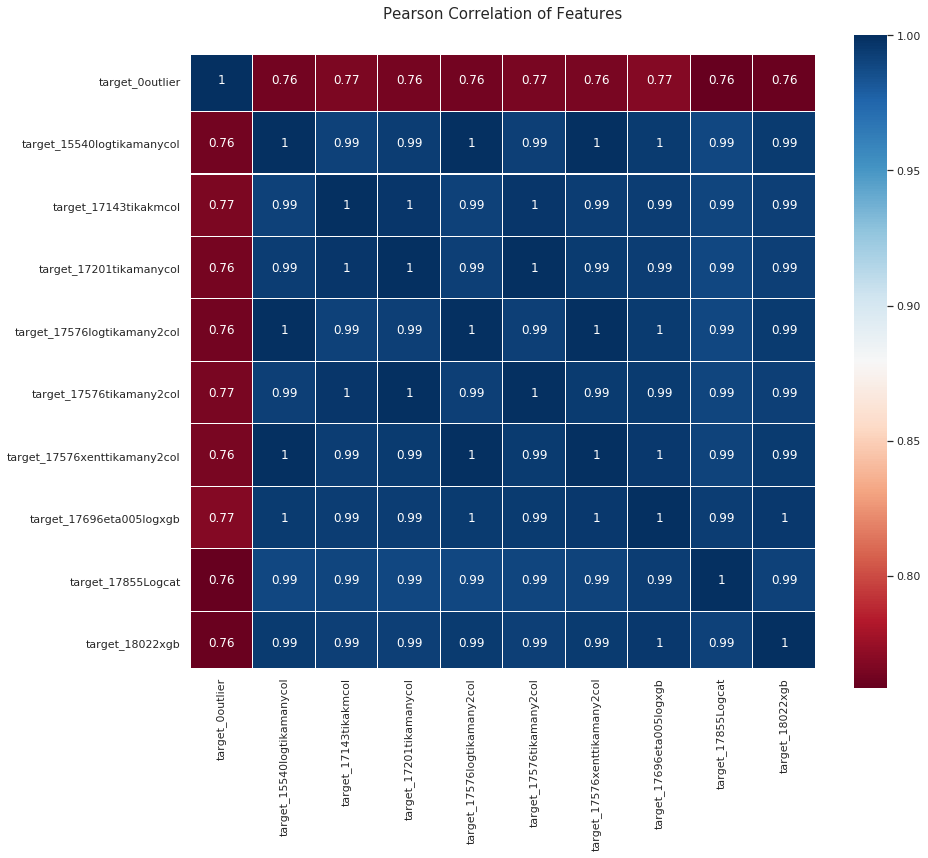

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(pred_df.drop(columns=['id','target']).astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

plt.ylim([oof_df.drop(columns=['id','target']).shape[1]- 0.1, 0.1])
plt.show()

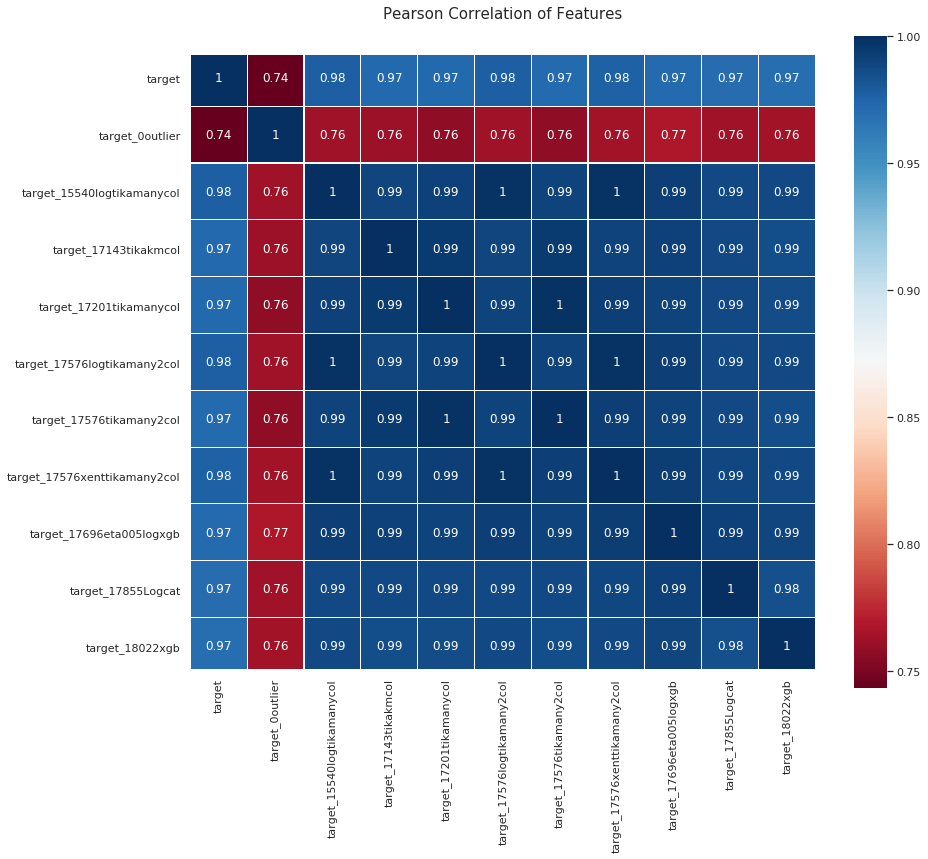

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(oof_df.drop(columns='id').astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

plt.ylim([oof_df.drop(columns='id').shape[1]- 0.1, 0.1])
plt.show()

In [126]:
y_train=oof_df['target']
X_train=oof_df.drop(columns=['target','id'])
X_test=pred_df.drop(columns=['target','id'])

In [127]:
folder=KFold(n_splits=20, shuffle=True, random_state=42)

In [154]:
lgbm_params = {
    'num_iterations': 50000,
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
#     'reg_lambda': 68.19849585036235,
#     'reg_alpha': 0.007585940082730346,
#     'colsample_bytree': 0.6,
#     'subsample': 0.5,
#     'max_depth': 8,
#     'min_child_weight': 8,
#     'lambda': 1,
#     'eta': 0.1,
    'verbose': 1,
    'random_state': 0,
    'early_stopping_round': 50
    }


# train

In [155]:
LGBM = LogRegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=lgbm_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
lgboof, lgbpreds, lgbFIs = LGBM.fit()

Training on fold 1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[482]	training's l1: 0.0517902	valid_1's l1: 0.0513628
Training on fold 2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[641]	training's l1: 0.0510778	valid_1's l1: 0.0537716
Training on fold 3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[509]	training's l1: 0.0516069	valid_1's l1: 0.0528881
Training on fold 4
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[698]	training's l1: 0.0510692	valid_1's l1: 0.0506027
Training on fold 5
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[658]	training's l1: 0.0511172	valid_1's l1: 0.0521348
Training on fold 6
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[613]	training's l1: 0.051239

### submit

In [156]:
pred_df['mean']=pred_df.drop(columns=['id','target']).mean(axis=1)

In [157]:
pred_df['pred']=lgbpreds

In [158]:
pred_df.loc[pred_df.query('50000<mean<500000').index,'mean']=pred_df.query('50000<mean<500000')['pred']

In [159]:
pred_df[['id','mean']].to_csv('./submit/1102_stacking2.csv',header=None,index=None)

RMSE :  21565.59141762427
R^2 :  0.9009678493918587


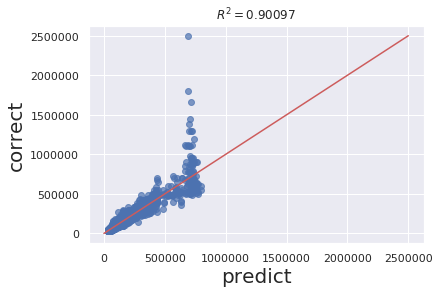

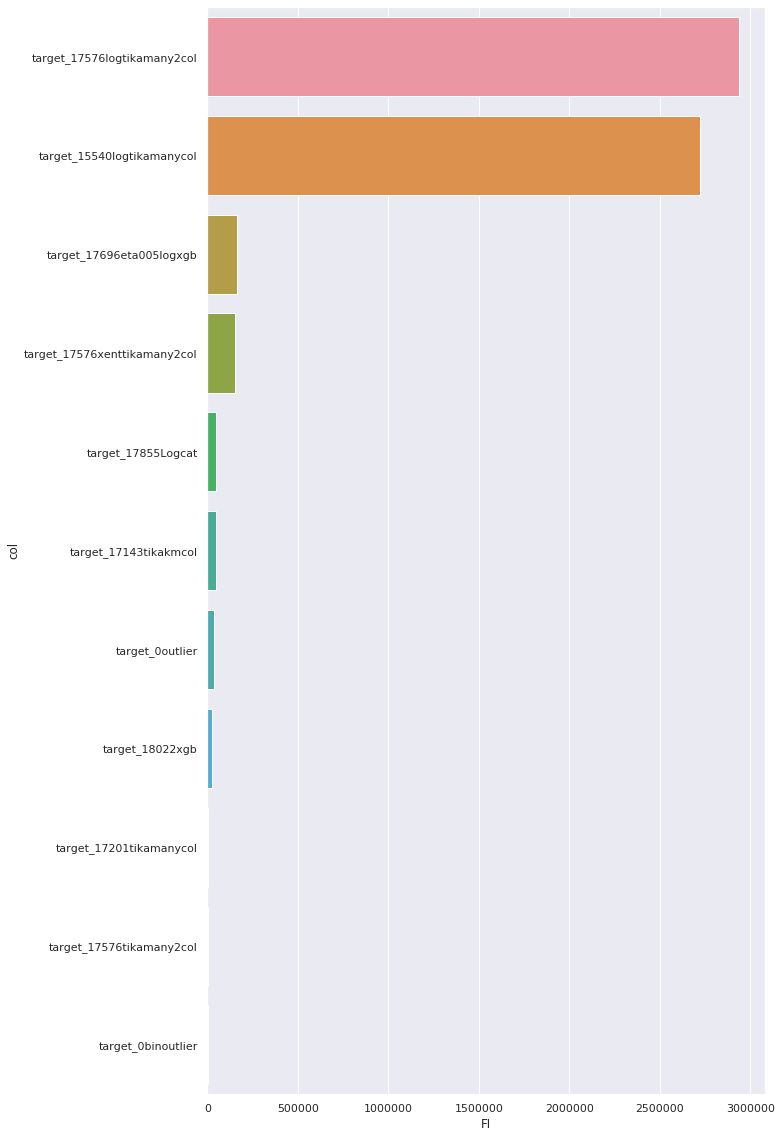

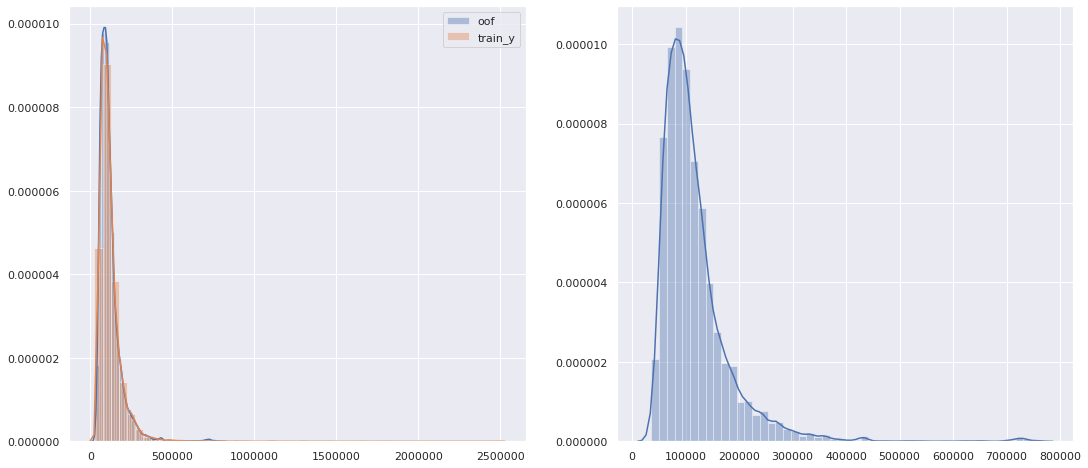

In [160]:
LGBM.plot_scatter_oofvspred()
LGBM.plot_FI(50)
LGBM.plot_pred_dist()

In [117]:
pred_df['mean'].sort_values()

7826     3.135166e+04
11713    3.179862e+04
10165    3.182962e+04
6240     3.242379e+04
10473    3.251353e+04
             ...     
30163    1.317261e+06
559      1.430241e+06
2184     1.516642e+06
2823     1.689935e+06
2032     1.901593e+06
Name: mean, Length: 31262, dtype: float64